Stacking of data

In [8]:
import pandas as pd


def process_files(file_paths):
    all_data = []

    for file_path in file_paths:
    
        data = pd.read_excel(file_path)
        
  
        print(f"Processing file: {file_path}")
        

        all_data.append(data)
    
 
    final_data = pd.concat(all_data, ignore_index=True)
    

    final_data.to_csv('stacked_data.csv', index=False)
    print("Data successfully stacked and saved to 'stacked_data.csv'.")


file_paths = ['Abdur Rafay_EEG_Segment.xlsx', 'Surya Jakka_EEG_Segment.xlsx', 'Michael_EEG_Segment.xlsx', 'Kushal Rao_EEG_Segment.xlsx', 'Omar O_EEG_Segment.xlsx', 'Jatin_EEG_Segment.xlsx']
process_files(file_paths)


Processing file: Abdur Rafay_EEG_Segment.xlsx
Processing file: Surya Jakka_EEG_Segment.xlsx
Processing file: Michael_EEG_Segment.xlsx
Processing file: Kushal Rao_EEG_Segment.xlsx
Processing file: Omar O_EEG_Segment.xlsx
Processing file: Jatin_EEG_Segment.xlsx
Data successfully stacked and saved to 'stacked_data.csv'.


Processing of DATA 

class distribution

Total number of rows: 1598968
Total number of columns: 31
Class Distribution:
emotion
Sad        446542
relax      354774
Happy      305410
Fear       284613
Excited    207629
Name: count, dtype: int64


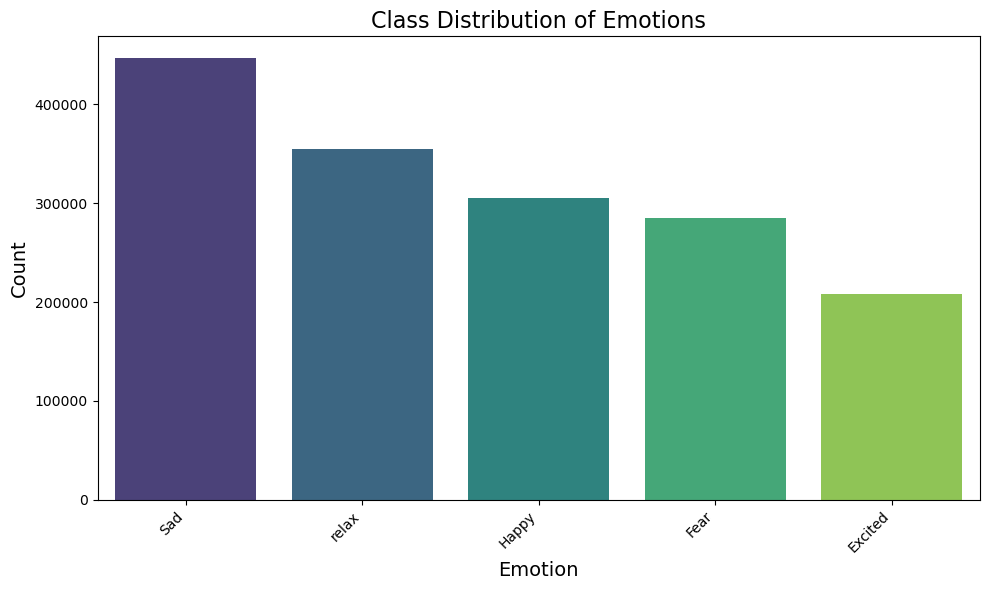

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('stacked_data.csv')


total_rows, total_columns = data.shape
print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")


class_distribution = data['emotion'].value_counts()
print("Class Distribution:")
print(class_distribution)


plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution of Emotions', fontsize=16)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


plt.savefig('class_distribution_plot.jpeg', format='jpeg', dpi=600)


plt.show()


Filtering for artifacts

Original number of rows: 1598968
Original number of columns: 30
Original unique classes in 'emotion': ['Sad' 'relax' 'Happy' 'Fear' 'Excited']

Filtered number of rows: 1598968
Filtered number of columns: 30
Filtered unique classes in 'emotion': ['Sad' 'relax' 'Happy' 'Fear' 'Excited']


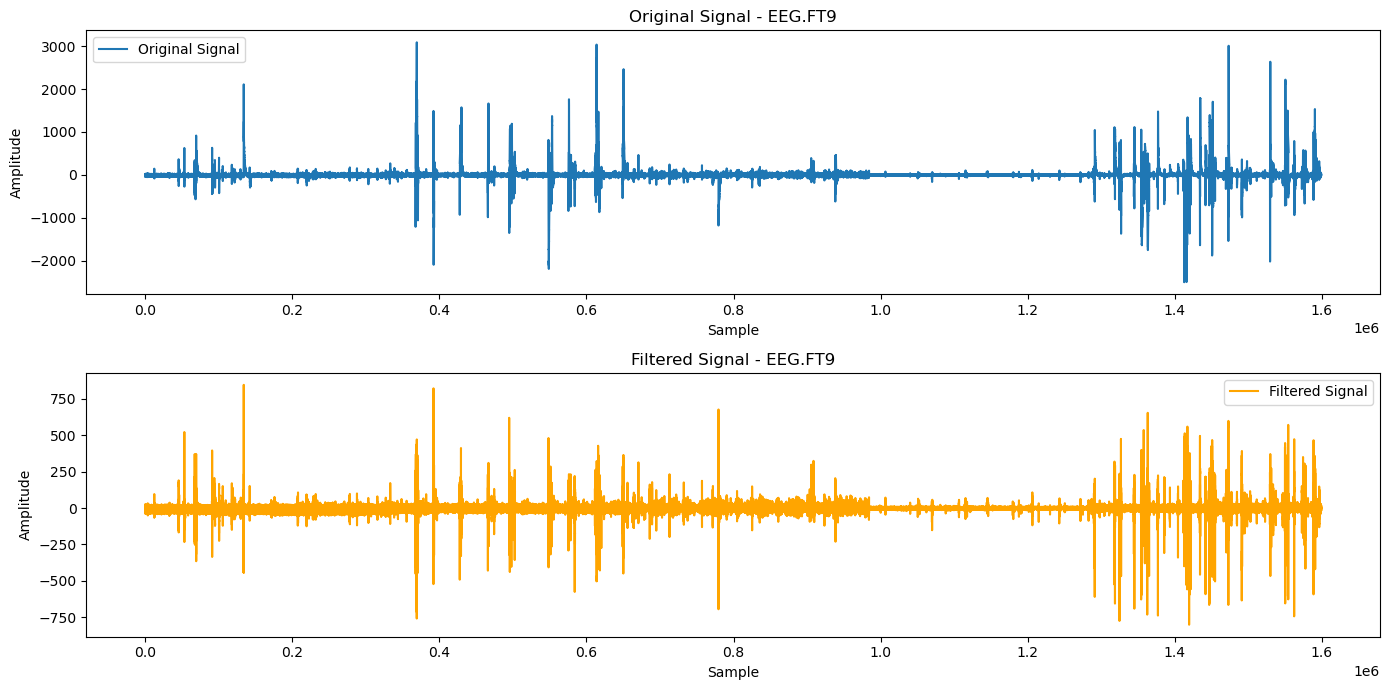

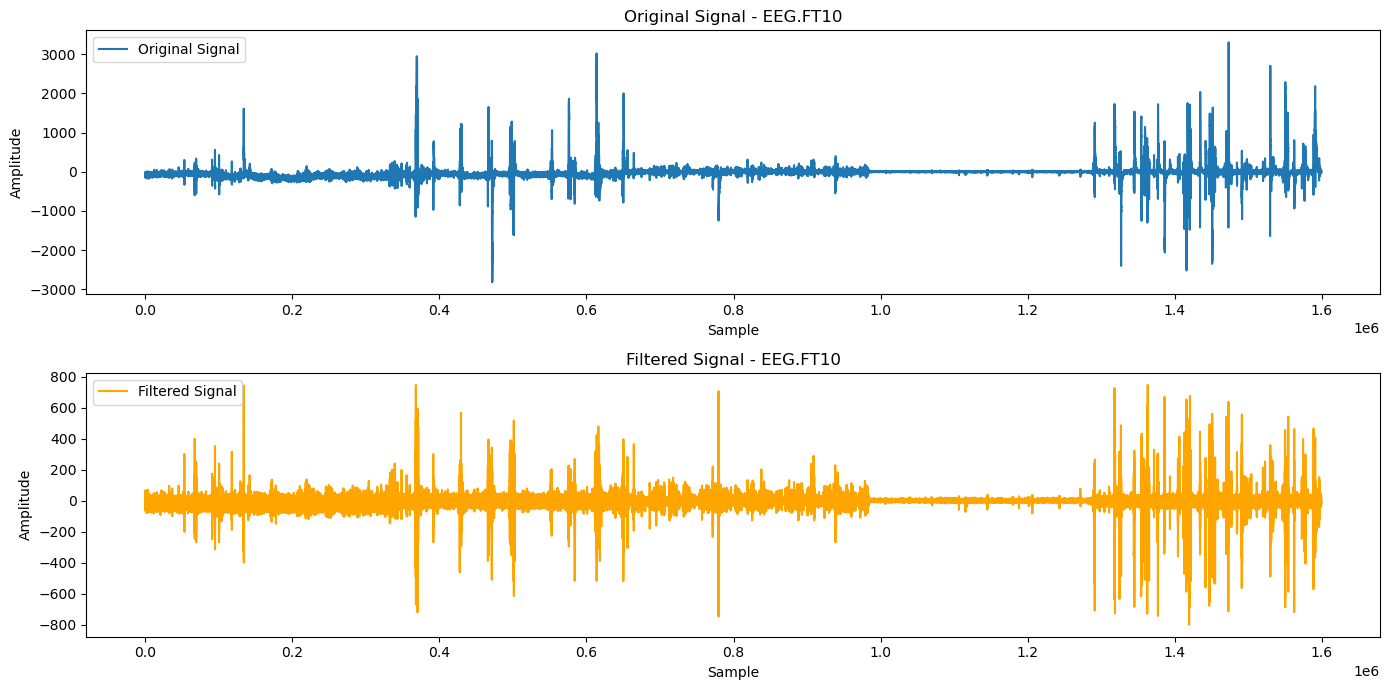

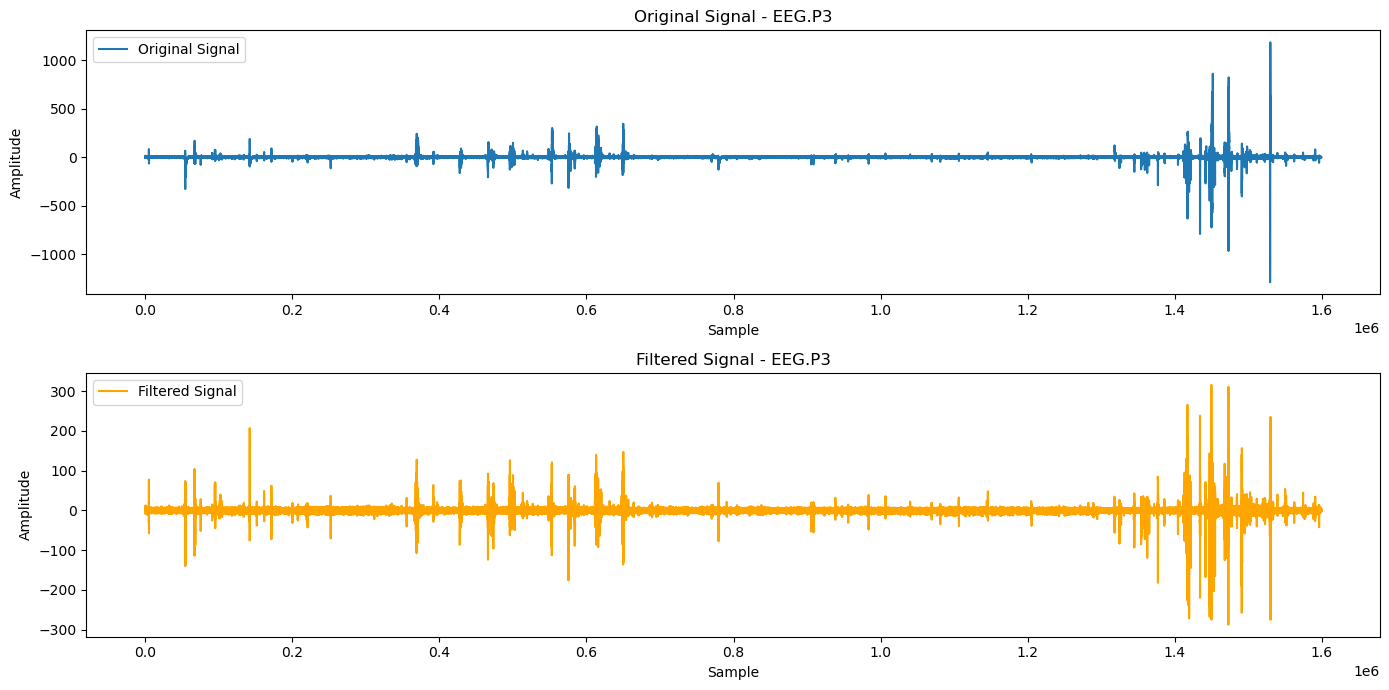

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


data = pd.read_csv('stacked_data.csv')


eeg_data = data.drop(columns=['Timestamp'])
labels = data['emotion']


eeg_data = eeg_data.apply(pd.to_numeric, errors='coerce')


original_rows, original_columns = eeg_data.shape
print(f"Original number of rows: {original_rows}")
print(f"Original number of columns: {original_columns}")
print(f"Original unique classes in 'emotion': {labels.unique()}")


low_cut = 0.5  
high_cut = 50  
sampling_frequency = 128 


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a


filtered_data = pd.DataFrame()


b, a = butter_bandpass(low_cut, high_cut, sampling_frequency, order=4)

for column in eeg_data.columns:
  
    signal = eeg_data[column].values  
    
 
    filtered_signal = filtfilt(b, a, signal)
    
 
    filtered_data[column] = filtered_signal


filtered_data['emotion'] = labels


filtered_rows, filtered_columns = filtered_data.shape
print(f"\nFiltered number of rows: {filtered_rows}")
print(f"Filtered number of columns: {filtered_columns}")
print(f"Filtered unique classes in 'emotion': {filtered_data['emotion'].unique()}")


filtered_data.to_csv('filtered_data_with_labels.csv', index=False)


channels_to_plot = ['EEG.FT9', 'EEG.FT10', 'EEG.P3']  

for channel in channels_to_plot:
    plt.figure(figsize=(14, 7))
    

    plt.subplot(2, 1, 1)
    plt.plot(eeg_data[channel].values, label='Original Signal')
    plt.title(f'Original Signal - {channel}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    

    plt.subplot(2, 1, 2)
    plt.plot(filtered_data[channel].values, label='Filtered Signal', color='orange')
    plt.title(f'Filtered Signal - {channel}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.tight_layout()
    

    plt.savefig(f'{channel}_signal_plot.jpeg', format='jpeg', dpi=600)
    

    plt.show()


In [ ]:
Statistical measures of filtered data

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch


data = pd.read_csv('filtered_data_with_labels.csv')


if 'Timestamp' in data.columns:
    data = data.drop(columns=['Timestamp'])


eeg_channels = [col for col in data.columns if col != 'emotion']


sampling_frequency = 128  
window_size = 2 
samples_per_window = sampling_frequency * window_size


bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 40)
}


windowed_features = []
windowed_labels = []


def compute_features_for_window(signal):
    features = {}
    
    # Statistical features
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['var'] = np.var(signal)
    features['rms'] = np.sqrt(np.mean(signal**2))
    features['skewness'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)
    features['min'] = np.min(signal)
    features['max'] = np.max(signal)
    features['percentile_25'] = np.percentile(signal, 25)
    features['percentile_75'] = np.percentile(signal, 75)
    features['iqr'] = np.percentile(signal, 75) - np.percentile(signal, 25) 
    features['peak_to_peak'] = np.max(signal) - np.min(signal) 
    features['zero_crossing_rate'] = np.sum(np.diff(np.sign(signal))) / len(signal)  

   
    freqs, psd = welch(signal, fs=sampling_frequency)
    features['mean_psd'] = np.mean(psd)
    
 
    for band, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)
        features[f'{band}_power'] = np.sum(psd[band_mask])
    
    return features


for start in range(0, len(data) - samples_per_window + 1, samples_per_window):
    end = start + samples_per_window
    
    window_data = data.iloc[start:end]
    window_label = window_data['emotion'].mode()[0]  
    
   
    features = {}
    for channel in eeg_channels:
        signal = window_data[channel].values
        channel_features = compute_features_for_window(signal)
        
  
        for feature_name, value in channel_features.items():
            features[f'{channel}_{feature_name}'] = value
    

    windowed_features.append(features)
    windowed_labels.append(window_label)


feature_df = pd.DataFrame(windowed_features)
feature_df['emotion'] = windowed_labels


feature_df.to_csv('eeg_windowed_features_no_candidates.csv', index=False)


print(f"Features extracted and saved to 'eeg_windowed_features_no_candidates.csv'.")
print(f"Total number of rows: {feature_df.shape[0]}")
print(f"Total number of columns: {feature_df.shape[1]}")
print("\nClass Distribution in 'emotion' column:")
print(feature_df['emotion'].value_counts())





Features extracted and saved to 'eeg_windowed_features_no_candidates.csv'.
Total number of rows: 6245
Total number of columns: 552

Class Distribution in 'emotion' column:
emotion
Sad        1747
relax      1378
Happy      1196
Fear       1113
Excited     811
Name: count, dtype: int64


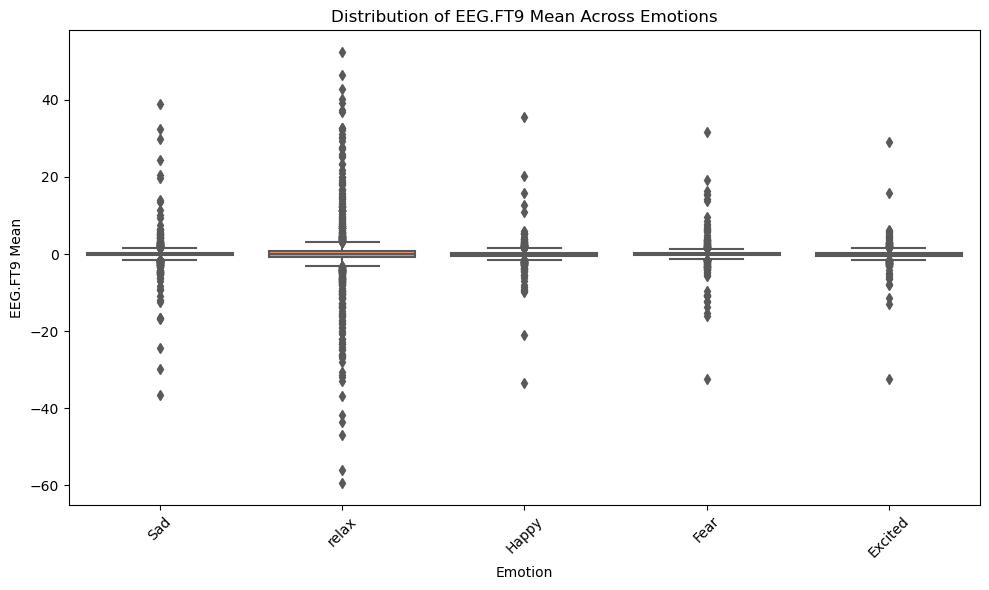

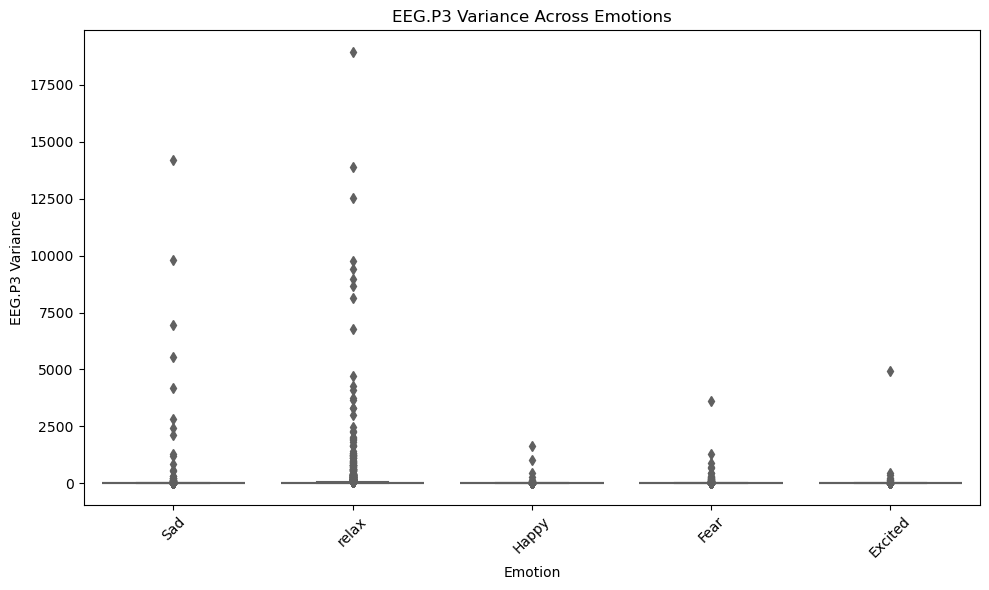

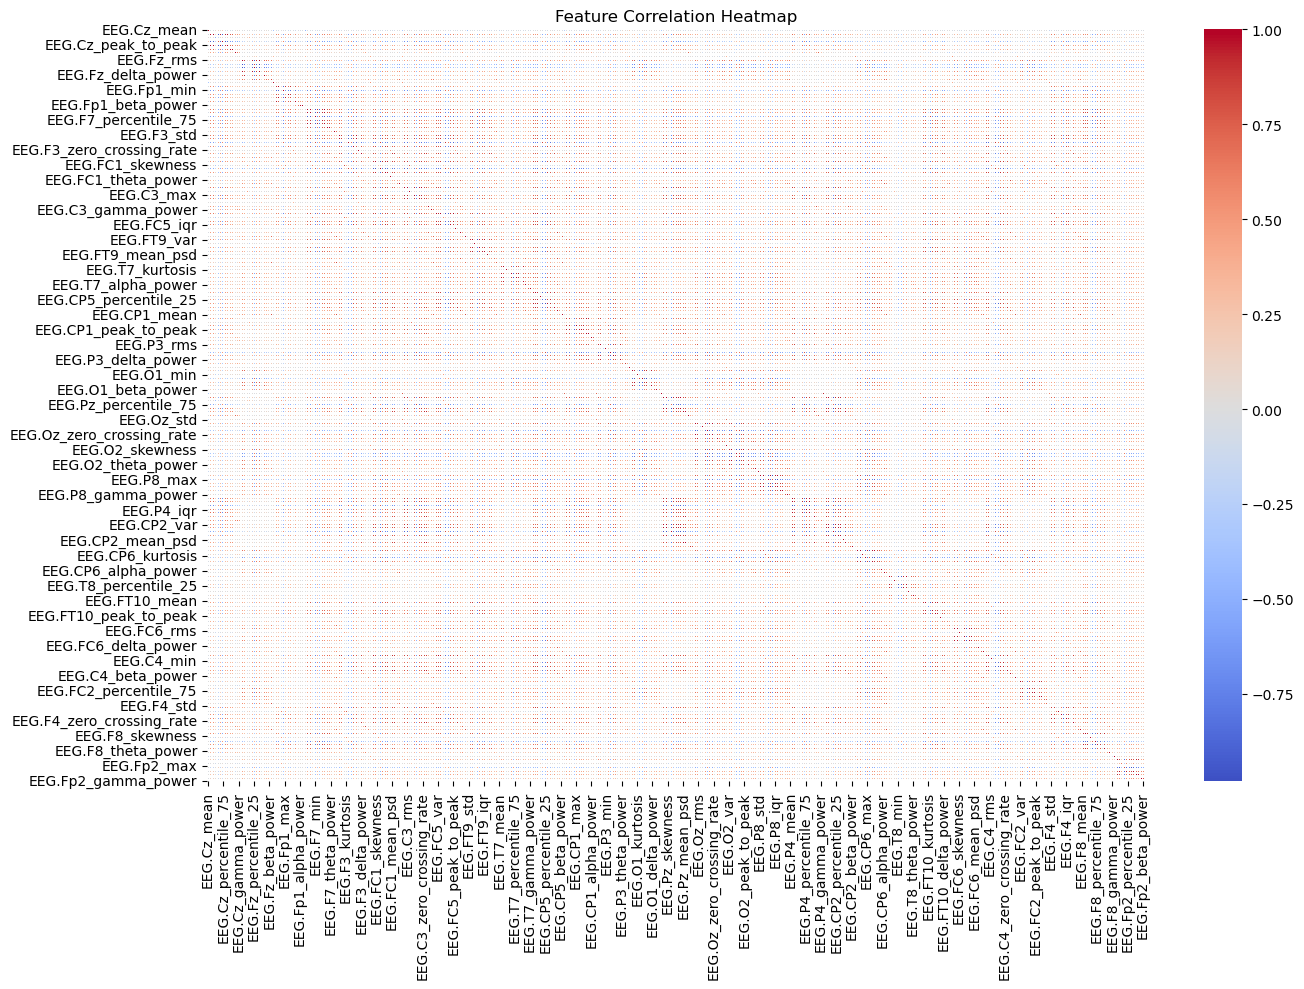

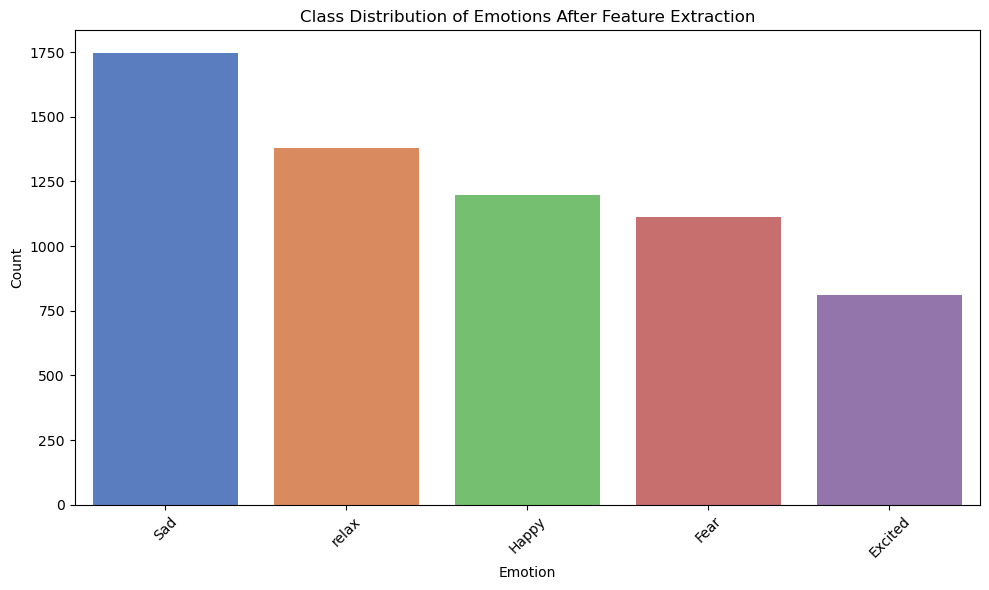

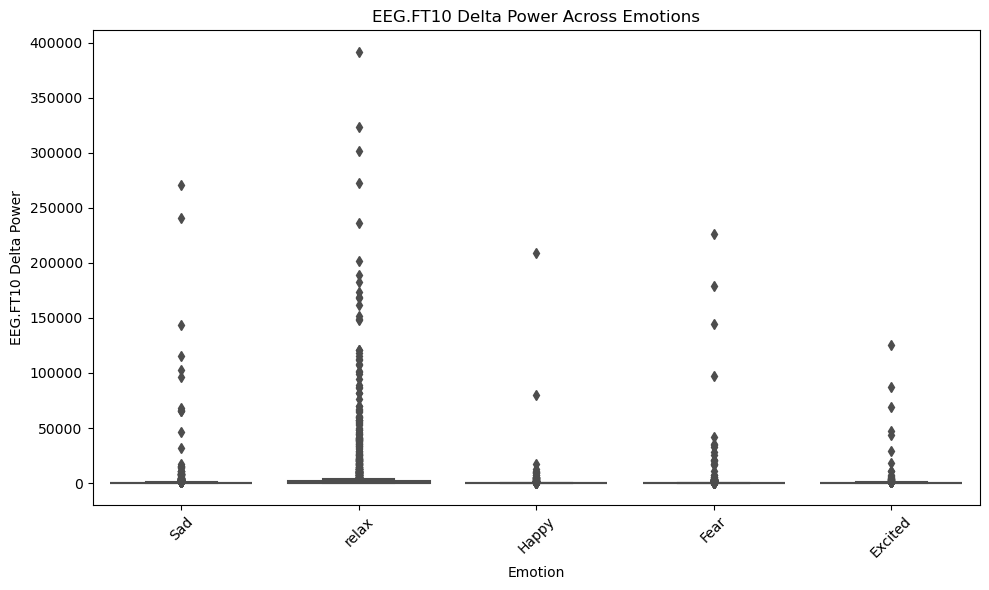

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


feature_df = pd.read_csv('eeg_windowed_features_no_candidates.csv')



plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='EEG.FT9_mean', data=feature_df, palette='Set2')
plt.title('Distribution of EEG.FT9 Mean Across Emotions')
plt.xlabel('Emotion')
plt.ylabel('EEG.FT9 Mean')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('EEG_FT9_mean_distribution.jpeg', format='jpeg', dpi=600)
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='EEG.P3_var', data=feature_df, palette='coolwarm')
plt.title('EEG.P3 Variance Across Emotions')
plt.xlabel('Emotion')
plt.ylabel('EEG.P3 Variance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('EEG_P3_variance_boxplot.jpeg', format='jpeg', dpi=600)
plt.show()


plt.figure(figsize=(14, 10))

numeric_features = feature_df.select_dtypes(include=[float, int])

correlation_matrix = numeric_features.corr()  
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('feature_correlation_heatmap.jpeg', format='jpeg', dpi=600)
plt.show()


plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=feature_df, palette='muted')
plt.title('Class Distribution of Emotions After Feature Extraction')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution_after_extraction.jpeg', format='jpeg', dpi=600)
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='EEG.FT10_delta_power', data=feature_df, palette='Spectral')
plt.title('EEG.FT10 Delta Power Across Emotions')
plt.xlabel('Emotion')
plt.ylabel('EEG.FT10 Delta Power')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('EEG_FT10_delta_power_boxplot.jpeg', format='jpeg', dpi=600)
plt.show()

In [ ]:
PCA over FE data

Columns in the filtered data with labels:
Index(['EEG.Cz_mean', 'EEG.Cz_std', 'EEG.Cz_var', 'EEG.Cz_rms',
       'EEG.Cz_skewness', 'EEG.Cz_kurtosis', 'EEG.Cz_min', 'EEG.Cz_max',
       'EEG.Cz_percentile_25', 'EEG.Cz_percentile_75',
       ...
       'EEG.Fp2_iqr', 'EEG.Fp2_peak_to_peak', 'EEG.Fp2_zero_crossing_rate',
       'EEG.Fp2_mean_psd', 'EEG.Fp2_delta_power', 'EEG.Fp2_theta_power',
       'EEG.Fp2_alpha_power', 'EEG.Fp2_beta_power', 'EEG.Fp2_gamma_power',
       'emotion'],
      dtype='object', length=552)


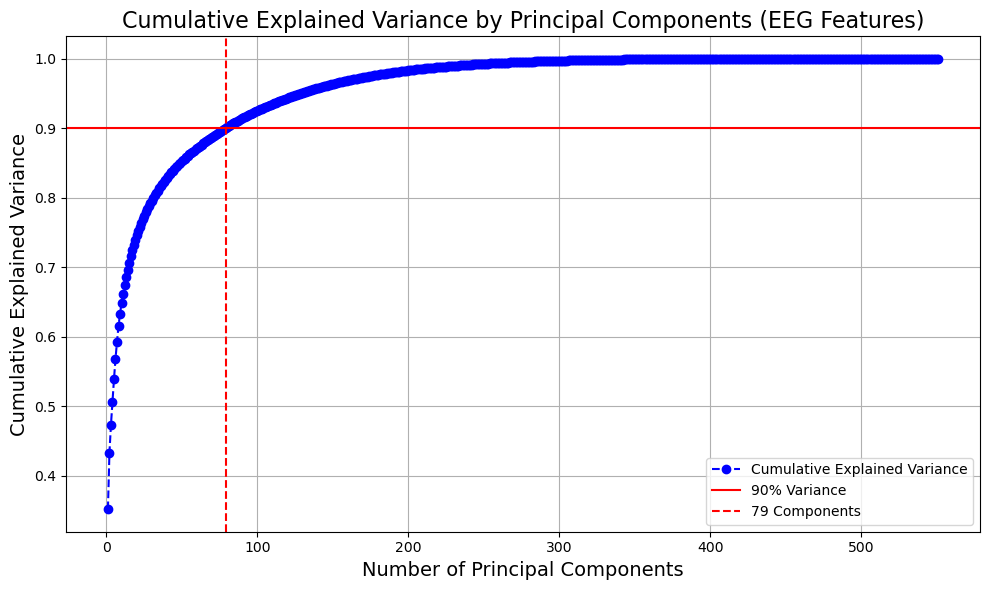

Total number of components: 551
Number of components explaining 90% of the variance: 79

PCA components saved to 'pca_components_with_labels.csv'.


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


filtered_data = pd.read_csv('eeg_windowed_features_no_candidates.csv')


print("Columns in the filtered data with labels:")
print(filtered_data.columns)


if 'emotion' not in filtered_data.columns:
    raise ValueError("The 'emotion' column is missing from the dataset.")


X_filtered = filtered_data.drop(columns=['emotion'], errors='ignore') 
y_filtered = filtered_data['emotion']  


scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)


pca_filtered = PCA()


X_pca_filtered = pca_filtered.fit_transform(X_scaled_filtered)


explained_variance_ratio_filtered = pca_filtered.explained_variance_ratio_


cumulative_variance_filtered = explained_variance_ratio_filtered.cumsum()


n_components_90_filtered = (cumulative_variance_filtered >= 0.90).argmax() + 1


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_filtered) + 1), cumulative_variance_filtered, 
         marker='o', linestyle='--', color='b', label='Cumulative Explained Variance')


plt.axhline(y=0.90, color='r', linestyle='-', label='90% Variance')


plt.axvline(x=n_components_90_filtered, color='r', linestyle='--', label=f'{n_components_90_filtered} Components')


plt.title('Cumulative Explained Variance by Principal Components (EEG Features)', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.grid(True)
plt.legend(loc='best')


plt.tight_layout()
plt.savefig('pca_cumulative_variance_90_percent.jpeg', format='jpeg', dpi=600)


plt.show()


total_components = len(explained_variance_ratio_filtered)
print(f"Total number of components: {total_components}")
print(f"Number of components explaining 90% of the variance: {n_components_90_filtered}")


pca_df = pd.DataFrame(data=X_pca_filtered[:, :n_components_90_filtered],  # Only the components explaining 90% variance
                      columns=[f'PC{i+1}' for i in range(n_components_90_filtered)])
pca_df['emotion'] = y_filtered.values  # Add the labels


pca_df.to_csv('pca_components_with_labels.csv', index=False)
print("\nPCA components saved to 'pca_components_with_labels.csv'.")


LDA over FE data

Columns in the filtered data with labels:
Index(['EEG.Cz_mean', 'EEG.Cz_std', 'EEG.Cz_var', 'EEG.Cz_rms',
       'EEG.Cz_skewness', 'EEG.Cz_kurtosis', 'EEG.Cz_min', 'EEG.Cz_max',
       'EEG.Cz_percentile_25', 'EEG.Cz_percentile_75',
       ...
       'EEG.Fp2_iqr', 'EEG.Fp2_peak_to_peak', 'EEG.Fp2_zero_crossing_rate',
       'EEG.Fp2_mean_psd', 'EEG.Fp2_delta_power', 'EEG.Fp2_theta_power',
       'EEG.Fp2_alpha_power', 'EEG.Fp2_beta_power', 'EEG.Fp2_gamma_power',
       'emotion'],
      dtype='object', length=552)


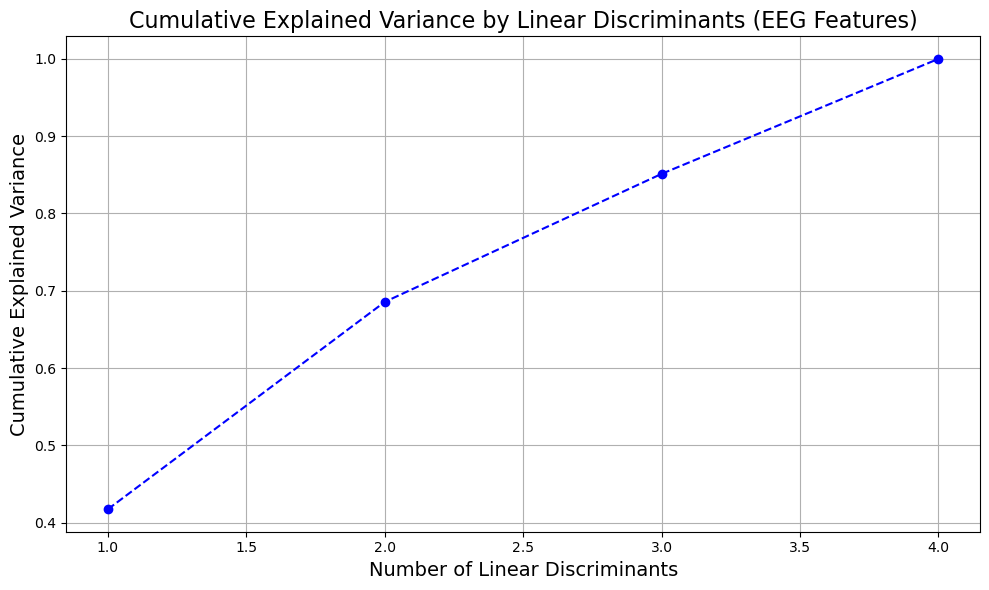


Cumulative Explained Variance Ratios for Each Linear Discriminant:
LD1: 0.4175
LD2: 0.6856
LD3: 0.8512
LD4: 1.0000


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
import numpy as np


filtered_data = pd.read_csv('eeg_windowed_features_no_candidates.csv')


print("Columns in the filtered data with labels:")
print(filtered_data.columns)


if 'emotion' not in filtered_data.columns:
    raise ValueError("The 'emotion' column is missing from the dataset.")


X_filtered = filtered_data.drop(columns=['emotion'], errors='ignore')  # Features
y_filtered = filtered_data['emotion']  # Labels


scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)


lda = LDA(n_components=len(y_filtered.unique()) - 1)  # LDA can have at most (number of classes - 1) components


lda.fit(X_scaled_filtered, y_filtered)


explained_variance_ratio_lda = lda.explained_variance_ratio_
cumulative_variance_lda = np.cumsum(explained_variance_ratio_lda)


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_lda) + 1), 
         cumulative_variance_lda, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Linear Discriminants (EEG Features)', fontsize=16)
plt.xlabel('Number of Linear Discriminants', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


print("\nCumulative Explained Variance Ratios for Each Linear Discriminant:")
for i, variance in enumerate(cumulative_variance_lda):
    print(f"LD{i + 1}: {variance:.4f}")


In [ ]:
SVM over FE data

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import random
import matplotlib.pyplot as plt
import seaborn as sns


seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)


data = pd.read_csv('eeg_windowed_features_no_candidates.csv')


X = data.drop(columns=['emotion'])
y = data['emotion']


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


def augment_data(X, y, noise_factor=0.1, num_augmented_per_class=3000):
    np.random.seed(seed_value)
    X_augmented = []
    y_augmented = []
    

    class_counts = np.bincount(y)


    for class_index in range(len(class_counts)):
        num_to_generate = max(0, num_augmented_per_class - class_counts[class_index])
        for _ in range(num_to_generate):
 
            idx = np.random.choice(np.where(y == class_index)[0])
            noise = noise_factor * np.random.randn(*X[idx].shape)
            X_augmented.append(X[idx] + noise)
            y_augmented.append(y[idx])
    
    return np.array(X_augmented), np.array(y_augmented)


X_augmented, y_augmented = augment_data(X.values, y_encoded)


X_combined = np.vstack((X.values, X_augmented))
y_combined = np.concatenate((y_encoded, y_augmented))


X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=seed_value, stratify=y_combined)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


svm_model = SVC(kernel='rbf', C=10, class_weight=class_weights_dict, max_iter=10000)


svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)


train_accuracy = accuracy_score(y_train, svm_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


C:\Users\Abdur Rafay\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Accuracy: 0.9102
Test Accuracy: 0.7947

Classification Report:
               precision    recall  f1-score   support

     Excited       0.75      0.90      0.82       600
        Fear       0.81      0.80      0.81       600
       Happy       0.77      0.76      0.77       600
         Sad       0.82      0.76      0.79       600
       relax       0.84      0.75      0.79       600

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.79      0.79      3000


Confusion Matrix:
 [[539  22  16   9  14]
 [ 59 480  26  16  19]
 [ 48  32 458  31  31]
 [ 33  38  50 455  24]
 [ 42  17  45  44 452]]


SVM over PCA data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Load the PCA dataset
data = pd.read_csv('pca_components_with_labels.csv')

# Prepare features and labels
X = data.drop(columns=['emotion'])  # Features from PCA components
y = data['emotion']  # Labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the SVM model with RBF kernel and C=10
svm_model = SVC(kernel='rbf', C=10, max_iter=10000)

# Fit the model on the entire resampled training data
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate training accuracy
train_accuracy = svm_model.score(X_train_resampled, y_train_resampled)

# Calculate test accuracy
test_accuracy = svm_model.score(X_test, y_test)

# Display performance metrics
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Display the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


SVM over LDA data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Load the LDA dataset
data = pd.read_csv('lda_components_with_labels.csv')

# Prepare features and labels
X = data.drop(columns=['emotion'])  # Features from LDA components
y = data['emotion']  # Labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the SVM model with RBF kernel and C=10
svm_model = SVC(kernel='rbf', C=10, max_iter=10000)

# Fit the model on the resampled training data
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict on the training set and test set
y_train_pred = svm_model.predict(X_train_resampled)
y_pred = svm_model.predict(X_test)

# Calculate training and test accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Display the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Deep Neural Netwrok on FE  DATA

C:\Users\Abdur Rafay\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2987 - loss: 2.4704 - val_accuracy: 0.4762 - val_loss: 1.2591 - learning_rate: 0.0010
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4456 - loss: 1.7619 - val_accuracy: 0.5250 - val_loss: 1.1487 - learning_rate: 0.0010
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4977 - loss: 1.5873 - val_accuracy: 0.5821 - val_loss: 1.0436 - learning_rate: 0.0010
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5416 - loss: 1.4646 - val_accuracy: 0.6012 - val_loss: 0.9993 - learning_rate: 0.0010
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5651 - loss: 1.3894 - val_accuracy: 0.6192 - val_loss: 0.9581 - learning_rate: 0.0010
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5965 - loss: 1.2958 - val_accuracy: 0.6363 - val_loss: 0.9173 - learning_rate: 0.0010
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6111 - loss: 1.

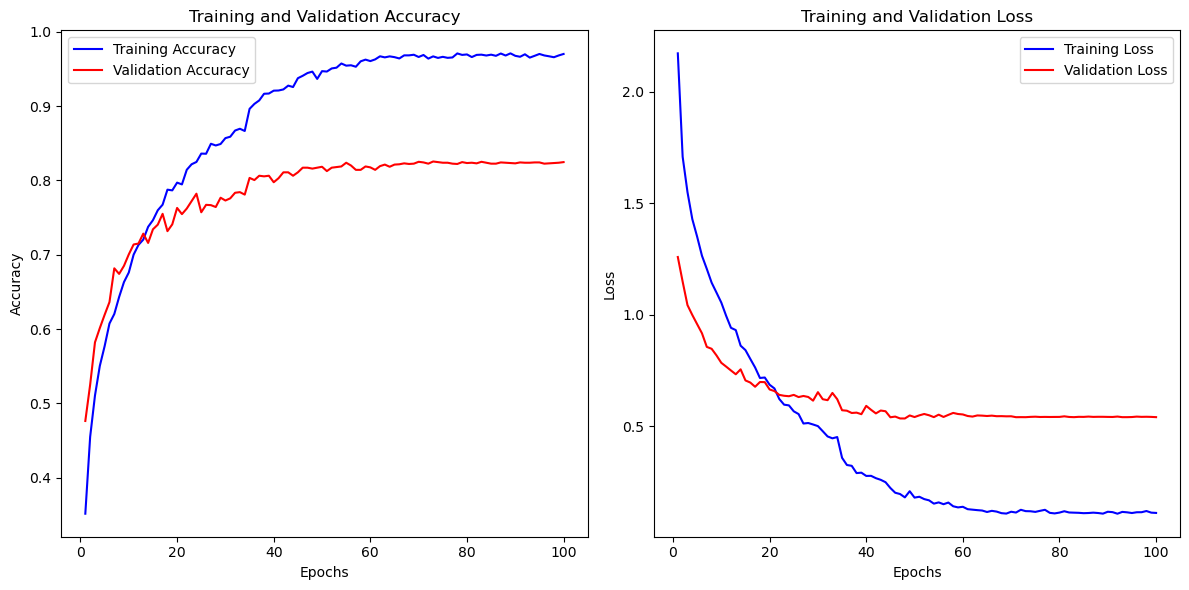

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       600
           1       0.75      0.87      0.80       600
           2       0.84      0.77      0.80       600
           3       0.79      0.76      0.78       600
           4       0.79      0.78      0.78       600

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000


Confusion Matrix:
 [[487  46  12  23  32]
 [ 22 521  14  17  26]
 [ 22  49 462  38  29]
 [ 24  48  36 456  36]
 [ 31  33  29  42 465]]


In [28]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf


seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)


data = pd.read_csv('eeg_windowed_features_no_candidates.csv')


X = data.drop(columns=['emotion'])  
y = data['emotion'] 


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


y_encoded = to_categorical(y_encoded)


def augment_data(X, y, noise_factor=0.1, num_augmented_per_class=3000):
    np.random.seed(seed_value)
    X_augmented = []
    y_augmented = []
    
 
    class_counts = np.bincount(np.argmax(y, axis=1))

  
    for class_index in range(len(class_counts)):
        num_to_generate = max(0, num_augmented_per_class - class_counts[class_index])
        for _ in range(num_to_generate):

            idx = np.random.choice(np.where(np.argmax(y, axis=1) == class_index)[0])
            noise = noise_factor * np.random.randn(*X[idx].shape)
            X_augmented.append(X[idx] + noise)
            y_augmented.append(y[idx])
    
    return np.array(X_augmented), np.array(y_augmented)


X_augmented, y_augmented = augment_data(X.values, y_encoded)


X_combined = np.vstack((X.values, X_augmented))
y_combined = np.vstack((y_encoded, y_augmented))


X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=seed_value, stratify=y_combined)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_classes),
    y=y_train_classes
)


class_weights_dict = {0: 1.4, 1: 1.4, 2: 1.5, 3: 1.0, 4: 1.2}


model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(y_combined.shape[1], activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.2, class_weight=class_weights_dict,
                    callbacks=[reduce_lr])


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


epochs = range(1, len(history.history['accuracy']) + 1)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes))


conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:\n", conf_matrix)
